In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 
import numpy as np
import argparse
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from EXP_module.src.model import NLA_r18
from EXP_module.src.utils import *
from EXP_module.src.resnet import *
torch.autograd.set_detect_anomaly(True)

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default="rafdb", type=str, choices=['rafdb', 'Ferplus', 'AffecNet'], help="experiment dataset")
parser.add_argument('--exp_name', default="NAW_NLA", type=str, choices=['NAW_NLA', 'NAW_CAM', 'NAW_L1', 'L1', 'CAM', 'JSD'], help="training strategy")
parser.add_argument('--open_set', default="None", type=str, choices=['Neutral', 'Happiness', 'Surprise', 'Disgust', 'Anger', 'Sadness', 'Fear'], help="open-set")
parser.add_argument('--dataset_path', type=str, default='/NLA/imgs/RAF-DB', help='raf_dataset_path')
parser.add_argument('--label_path', type=str, default='/NLA/imgs/list_patition_label.txt', help='label_path')
parser.add_argument('--num_classes', type=int, default=7)
parser.add_argument('--feature_embedding', type=int, default=512)
parser.add_argument('--batch_size', type=int, default=32, help='batch_size')
parser.add_argument('--workers', type=int, default=4, help='number of workers')
parser.add_argument('--gpu', type=int, default=0, help='the number of the device')
# other setting
parser.add_argument('--noise', type=bool, default=False, help='learning from noise label')  
parser.add_argument('--imbalanced', type=bool, default=False, help='learning from imbalanced label')
parser.add_argument('--seed', type=int, default=11111135)
args = parser.parse_args([])

In [3]:
eval_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.577, 0.4494, 0.4001],
                        std=[0.2628, 0.2395, 0.2383])])


In [4]:
cp = torch.load('/NLA/EXP_module/weights/best.pth')

In [5]:
model = NLA_r18(args)

In [6]:
model.load_state_dict(cp)
device = torch.device('cuda:{}'.format(args.gpu))
model.to(device)
model.eval()

NLA_r18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [7]:
from PIL import Image
import os

# 수정된 eval_transforms (ToPILImage 제거)
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 변경
    transforms.ToTensor(),  # PIL 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.577, 0.4494, 0.4001],
                         std=[0.2628, 0.2395, 0.2383])  # 정규화
])

# 이미지 경로에서 이미지 로드 및 변환
def process_image(image_path):
    # 파일 확장자 확인 (jpg, png만 처리)
    if not image_path.lower().endswith(('jpg', 'png')):
        raise ValueError("지원되지 않는 파일 형식입니다. jpg 또는 png 파일만 지원합니다.")
    
    image = Image.open(image_path).convert("RGB")  # RGB로 변환
    image = eval_transforms(image)  # 변환 적용
    
    # 배치 차원을 추가하여 배치 단위로 만들기
    image = image.unsqueeze(0)  # 배치 크기 1로 설정
    return image

# 이미지 경로 예시
image_path = '/NLA/anger_me.png'

# 이미지 처리
image_tensor = process_image(image_path)


# GPU 사용 여부 확인 및 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
image_tensor = image_tensor.to(device)

In [9]:
image_tensor.shape

torch.Size([1, 3, 224, 224])

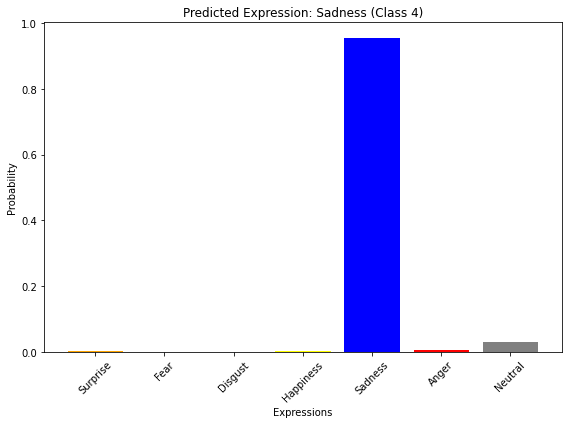

Predicted Class: Sadness (4)
Class Probabilities: [4.0059825e-03 1.2561899e-03 2.0949868e-04 2.2659958e-03 9.5397800e-01
 7.2093173e-03 3.1075066e-02]


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Softmax

# exp_dict 정의
exp_dict = {0: 'Surprise', 1: 'Fear', 2: 'Disgust', 3: 'Happiness', 4: 'Sadness', 5: 'Anger', 6: 'Neutral'}

# 클래스별 색상 지정 (원하는 색으로 자유롭게 바꿔도 됩니다)
colors = ['orange', 'purple', 'green', 'yellow', 'blue', 'red', 'gray']

# 모델에 입력하고 예측 결과 얻기
with torch.no_grad():  # gradient 계산 비활성화 (추론 모드)
    output = model(image_tensor)

# 소프트맥스 적용
softmax = Softmax(dim=1)
probabilities = softmax(output)

# 배치 차원 제거 및 NumPy 변환
probabilities = probabilities.squeeze(0).cpu().numpy()

# 예측된 클래스 및 라벨
predicted_class = np.argmax(probabilities)
predicted_label = exp_dict[predicted_class]

# 확률 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(exp_dict.values(), probabilities, color=colors)  # color 지정
plt.xlabel('Expressions')
plt.ylabel('Probability')
plt.title(f'Predicted Expression: {predicted_label} (Class {predicted_class})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 예측 정보 출력
print(f"Predicted Class: {predicted_label} ({predicted_class})")
print("Class Probabilities:", probabilities)
